## JUMIA-PRODUCTS-RECOMMENDATION-AND-PRODUCT-REVIEW-SYSTEM

### Overview

The growth of e-commerce in Kenya has been exponential, with platforms like Jumia attracting large numbers of users. However, users frequently encounter challenges in locating relevant products due to expansive and sometimes disorganized product catalogs. Moreover, the limited use of recommendations and unreliable review systems further complicate the shopping experience, leading to reduced user satisfaction and lower conversion rates. To address these issues, we propose a recommendation and sentiment analysis system that leverages interaction history and user feedback. This system aims to provide more relevant recommendations and insights from customer sentiments, enabling Jumia to better serve its users and enhance its retail offerings.

### Problem Statement

The problem of finding relevant products on Jumia’s extensive catalog significantly affects customer satisfaction and conversion rates. Current limitations include:  

* Inadequate product recommendations based on user behavior, which leads to a lack of personalization.
* An unreliable rating and review system, leaving customers with limited insights into product quality.
* Limited retailer insights into customer sentiment, hindering their ability to refine offerings and optimize marketing strategies.
  
These issues reduce user satisfaction, decrease sales, and limit the potential for enhanced customer-retailer relationships on Jumia.

### Stakeholders

**Primary Users (Consumers)**: Customers who frequently shop on Jumia and need relevant recommendations to streamline their product search and improve purchase decisions.

**Retailers/Sellers**: Businesses and individual sellers on Jumia who seek insights into customer preferences and sentiment to better tailor their product offerings and marketing strategies.

**Jumia Management**: The platform administrators who aim to improve customer satisfaction, engagement, and conversion rates through improved site functionality.

### Objectives

* *Develop a Recommendation System*:

Create an intelligent recommendation engine that uses customer interaction history, preferences, and similar behavior patterns to provide relevant product recommendations.

* *Implement Sentiment Analysis*:

Extract sentiments from customer reviews to offer meaningful feedback, categorizing it as positive, negative, or neutral. This feedback will help refine recommendations and improve customer trust in the platform.

* *Enhance User Experience*:

Improve customer satisfaction by reducing the time and effort needed to find relevant products, potentially increasing conversion rates.

* *Provide Insightful Retailer Analytics*:

Equip sellers with sentiment analysis reports and recommendation patterns to refine product and marketing offerings based on customer preferences.

* *Support Kenyan E-commerce Growth*:

Contribute to the development of the e-commerce sector in Kenya by addressing key pain points in product discoverability and review reliability on Jumia.

### Expected Benefits

* **For Customers**: More personalized recommendations, improved trust through reliable sentiment analysis, and an overall enhanced shopping experience.

* **For Retailers**: Access to better customer insights and sentiment data, allowing them to optimize product listings, improve customer engagement, and refine marketing strategies.

* **For Jumia**: Increased user satisfaction and conversion rates, resulting in stronger brand loyalty and a more competitive edge in the Kenyan e-commerce market.

### Data Understanding

We scraped data from [jumia](https://www.jumia.co.ke/) which is an online shop with more than 15 categories of products but decided to only have 15 categories

### Exploratory Data Ananlysis

Importing relevant libraries

In [265]:
#import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE 
from scipy import stats as stats
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,\
roc_curve,roc_auc_score,classification_report, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import re

import warnings
warnings.filterwarnings('ignore')

### Data Understanding

Loading the scraped dataset

In [266]:
# Load the data into a dataframe and read the first five rows
df = pd.read_csv('./Data/combined_dta.csv', encoding='ISO-8859-1')

df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLaptop Skin Wrap Vinyl from 1...,https://www.jumia.co.ke/generic-laptop-skin-wr...,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,KSh 699 - KSh 797,NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,See All,https://www.jumia.co.ke/catalog/productratings...,OKAY,"Working, feels cheap",3 out of 5,by WILFRED,28/04/2022,NaN,NaN,Computing
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,325",NaN,NaN,https://www.jumia.co.ke/computer-accessories/?...,See All,https://www.jumia.co.ke/catalog/productratings...,okay,A bit big for a regular laptop bag... The fanc...,4 out of 5,by Michael,8/7/2021,NaN,NaN,Computing
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop ...",https://www.jumia.co.ke/lexar-2.5-sata-256gb-l...,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 3,799",Lexar,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-h...,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,"KSh 15,000",WD,NaN,https://www.jumia.co.ke/computer-accessories/?...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Computing


In [267]:
# Get the number of rows and columns
print(df.shape, '\n')

print(f'The scraped data have {df.shape[0]} rows and {df.shape[1]} columns')

(60464, 20) 

The scraped data have 60464 rows and 20 columns


To arrive at this number of rows, we ensured that we scraped as much data as possible both from the product categories and sub-categories despite being blocked from sourcing most of it but we believe that this dataset will be helpful in achieving our objectives

In [268]:
# Statistical summary

df.describe()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,link,link-href,see_all,see_all-href,review_title,review,ratings,user_name,date,see_all_link,see_all_link-href,Category
count,60464,60464,60464,60464,60464,60431,60431,39584,28043,35931,40431,40432,37705,40208,37717,37717,37717,51,51,60464
unique,60226,216,25444,26683,22874,26650,7994,1690,4,622,3,7817,13071,25610,6,9261,1935,1,1,14
top,?web-scraper-order,https://www.jumia.co.ke/mobile-phones/,Black Friday dealOut of StockOfficial StoreHis...,https://www.jumia.co.ke/hisense-ax-3100g-3.1ch...,Hisense AX-3100G 3.1ch Dolby Atmos Home Cinema...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,KSh 999,Fashion,2,https://www.jumia.co.ke/mobile-phones/?page=2#...,See All,https://www.jumia.co.ke/catalog/productratings...,I like it,Good,5 out of 5,by Brian,11/10/2024,see_all_link,see_all_link-href,Fashion
freq,51,1448,192,192,192,192,528,10798,15101,488,37858,192,3389,309,21726,366,470,51,51,11684


In [269]:
# Let's look at the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60464 entries, 0 to 60463
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   web-scraper-order      60464 non-null  object
 1   web-scraper-start-url  60464 non-null  object
 2   product                60464 non-null  object
 3   product-href           60464 non-null  object
 4   product_name           60464 non-null  object
 5   image                  60431 non-null  object
 6   price                  60431 non-null  object
 7   brand                  39584 non-null  object
 8   link                   28043 non-null  object
 9   link-href              35931 non-null  object
 10  see_all                40431 non-null  object
 11  see_all-href           40432 non-null  object
 12  review_title           37705 non-null  object
 13  review                 40208 non-null  object
 14  ratings                37717 non-null  object
 15  user_name          

In [270]:
print(f'We have {df.shape[1]} columns in our dataset', '\n')

print('The columns are:')

df.columns

We have 20 columns in our dataset 

The columns are:


Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'link', 'link-href',
       'see_all', 'see_all-href', 'review_title', 'review', 'ratings',
       'user_name', 'date', 'see_all_link', 'see_all_link-href', 'Category'],
      dtype='object')

To have better understanding of what each column entails and what they mean, have a look at the `column_description.txt` file in the `Data` folder

### Data Cleaning

In [271]:
# Checks for row duplicates
df.duplicated().sum()

49

In [272]:
# Remove row duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [273]:
print(f'After dropping the 53 rows with duplicates, we now remaining with {df.shape[0]} rows and {df.shape[1]} columns')

After dropping the 53 rows with duplicates, we now remaining with 60415 rows and 20 columns


In [274]:
# Function to calculate the percentage of null values in every column

def null_percentages(df):
    
    # Calculate the number of missing values and their percentage
    null_values = df.isnull().sum()
    null_percentage = (null_values / df.shape[0]) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Null Values': null_values, 'Percentage': null_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Null Values'] > 0].sort_values(by='Null Values', ascending=False)

    return missing_data

In [275]:
null_percentages(df)

,Null Values,Percentage
see_all_link,60413,99.996690
see_all_link-href,60413,99.996690
link,32421,53.663825
link-href,24533,40.607465
review_title,22759,37.671108
ratings,22747,37.651246
user_name,22747,37.651246
date,22747,37.651246
brand,20880,34.560953
review,20256,33.528097


We have lots of columns with over **35%** null values and so, we are going to of how to deal with the null values and at the same time maintain as much data as possible  

Let's plot a heat map for the missing values

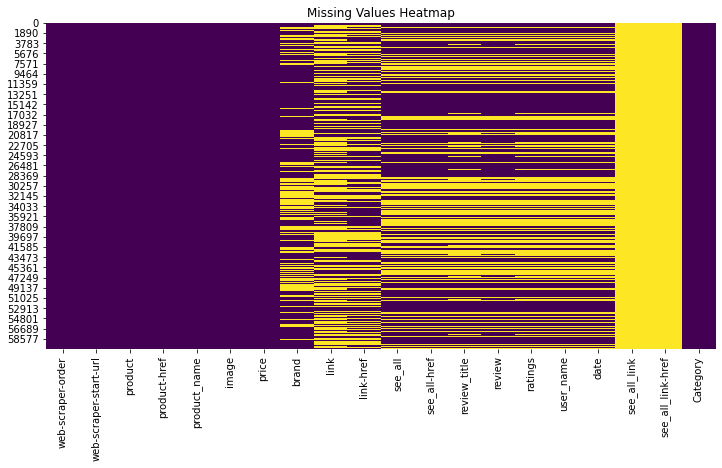

In [276]:
# Plot missing values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show();

Notable Columns with Missing Data:

`review_title`  
`link-href`   
`user_rating`   
Several columns related to scraping and product information

*Data Quality Implications*:

This visualization helps identify:

* Which columns need data cleaning
* Patterns of missing data that might indicate scraping issues
* Columns that might need to be dropped or imputed
* Potential systematic issues in data collection

In [277]:
df.drop(['see_all_link-href', 'see_all_link', 'see_all-href', 'see_all', 'link-href', 'link'], axis=1, inplace=True,)
df.shape

(60415, 14)

In [278]:
df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'product', 'product-href',
       'product_name', 'image', 'price', 'brand', 'review_title', 'review',
       'ratings', 'user_name', 'date', 'Category'],
      dtype='object')

We are now remaining with 14 columns. 

Since we have got further information that we need from other columns, we going to extract **ratings** from `ratings` column, **sub_category** from `web-scraper-start-url` column, **overall_ratings** from `product` column and **rating_count** from `product` column

In [279]:
# Extract ratings, sub_category, overall_ratings, date, month, year and ratings_count

df['ratings'] = df['ratings'].str.extract(r'(\d+)').astype(float)

df['sub_category'] = df['web-scraper-start-url'].str.extract(r'\.ke/([^/]+)/')

df['overall_ratings'] = df['product'].str.extract(r'(\d+(\.\d+)?) out of 5')[0]

df['ratings_count'] = df['product'].str.extract(r'(\d+) out of 5\((\d+)\)')[1].astype(float)

In [280]:
# Stripping 'by' from user_name

df['user_name'] = df['user_name'].str.lstrip('by')

In [281]:
# parse the dates, currently coded as strings, into datetime format

df['date'] = pd.to_datetime(df['date'],  dayfirst=True, errors='coerce')

In [282]:
# extract year from date
df['year'] = df['date'].dt.year

# extract month from date
df['month'] = df['date'].dt.month

# extract day from date
df['day'] = df['date'].dt.day

In [283]:
# Function to remove the currency and calculate the average of the price range

def convert_price(price):
    # Remove non-numeric characters (i.e.currency symbols)
    cleaned_price = re.sub(r"[^\d.-]", "", str(price))
    
    # Handle ranges
    if '-' in cleaned_price:
        try:
            low, high = map(float, cleaned_price.split('-'))
            return (low + high) / 2
        except ValueError:
            return None  # Return None if conversion fails
    else:
        try:
            return float(cleaned_price)  # Convert single prices to float
        except ValueError:
            return None

In [284]:
# Apply the conversion function to the price column

df['price'] = df['price'].apply(convert_price)

In [285]:
# Show the first 5 rows of the DataFrame

df.head()

,web-scraper-order,web-scraper-start-url,product,product-href,product_name,image,price,brand,review_title,review,ratings,user_name,date,Category,sub_category,overall_ratings,ratings_count,year,month,day
0,1730407108-1,https://www.jumia.co.ke/computer-accessories/,Black Friday dealLaptop Skin Wrap Vinyl from 1...,https://www.jumia.co.ke/generic-laptop-skin-wr...,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,748.0,NaN,NaN,NaN,NaN,NaN,NaT,Computing,computer-accessories,NaN,NaN,NaN,NaN,NaN
1,1730407112-2,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,OKAY,"Working, feels cheap",3.0,WILFRED,2022-04-28,Computing,computer-accessories,4.1,7.0,2022.0,4.0,28.0
2,1730407112-3,https://www.jumia.co.ke/computer-accessories/,"Black Friday deal9""-17"" Laptop Cooling Stand P...",https://www.jumia.co.ke/9-17-laptop-cooling-st...,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,2021-07-08,Computing,computer-accessories,4.1,7.0,2021.0,7.0,8.0
3,1730407114-4,https://www.jumia.co.ke/computer-accessories/,"Black Friday dealLexar 2.5"" SATA 256GB Laptop ...",https://www.jumia.co.ke/lexar-2.5-sata-256gb-l...,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3799.0,Lexar,NaN,NaN,NaN,NaN,NaT,Computing,computer-accessories,NaN,NaN,NaN,NaN,NaN
4,1730407116-5,https://www.jumia.co.ke/computer-accessories/,"WD External Portable Hard Drive-2TBKSh 15,000",https://www.jumia.co.ke/wd-external-portable-h...,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,15000.0,WD,NaN,NaN,NaN,NaN,NaT,Computing,computer-accessories,NaN,NaN,NaN,NaN,NaN


In [286]:
print(f'We have {df.shape[0]} rows and {df.shape[1]} columns after extraction and addition of new columns')

We have 60415 rows and 20 columns after extraction and addition of new columns


We now going to remove columns that are no longer useful

In [287]:
df.drop(['web-scraper-start-url', 'product', 'product-href', 'date'], axis=1, inplace=True)

In [288]:
df.head()

,web-scraper-order,product_name,image,price,brand,review_title,review,ratings,user_name,Category,sub_category,overall_ratings,ratings_count,year,month,day
0,1730407108-1,Laptop Skin Wrap Vinyl from 12-17.0 inches Lap...,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,748.0,NaN,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN,NaN,NaN,NaN
1,1730407112-2,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,OKAY,"Working, feels cheap",3.0,WILFRED,Computing,computer-accessories,4.1,7.0,2022.0,4.0,28.0
2,1730407112-3,"9""-17"" Laptop Cooling Stand Pad",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3325.0,NaN,okay,A bit big for a regular laptop bag... The fanc...,4.0,Michael,Computing,computer-accessories,4.1,7.0,2021.0,7.0,8.0
3,1730407114-4,"Lexar 2.5"" SATA 256GB Laptop SSD",https://ke.jumia.is/unsafe/fit-in/680x680/filt...,3799.0,Lexar,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN,NaN,NaN,NaN
4,1730407116-5,WD External Portable Hard Drive-2TB,https://ke.jumia.is/unsafe/fit-in/680x680/filt...,15000.0,WD,NaN,NaN,NaN,NaN,Computing,computer-accessories,NaN,NaN,NaN,NaN,NaN


In [289]:
# Check for null values and their percentage

null_percentages(df)

,Null Values,Percentage
year,29361,48.598858
month,29361,48.598858
day,29361,48.598858
review_title,22759,37.671108
ratings,22749,37.654556
user_name,22747,37.651246
brand,20880,34.560953
overall_ratings,20583,34.069354
ratings_count,20583,34.069354
review,20256,33.528097


As per the above output, `year`, `month`, `day` have **48.66%** missing values each, followed closed by `ratings`, `user_name` and `review_title` which have over **35%** missing values  

Let's have a look at the statistical summary for the numerical columns

In [290]:
df.describe()

,price,ratings,ratings_count,year,month,day
count,6.038000e+04,37666.000000,39832.000000,31054.000000,31054.000000,31054.000000
mean,5.253730e+03,4.056762,90.309148,2023.323276,7.242803,14.369840
std,1.765041e+04,1.358256,281.202628,1.078499,2.983382,8.862492
min,3.000000e+01,1.000000,1.000000,2017.000000,1.000000,1.000000
25%,7.248750e+02,3.000000,12.000000,2023.000000,5.000000,7.000000
50%,1.390000e+03,5.000000,31.000000,2024.000000,8.000000,13.000000
75%,3.849250e+03,5.000000,71.000000,2024.000000,10.000000,22.000000
max,1.370668e+06,5.000000,5225.000000,2024.000000,12.000000,31.000000


#### Imputation

In [291]:
# Impute less critical columns

df['brand'].fillna('Unknown', inplace=True)

df['review_title'].fillna('No Title', inplace=True)

df['user_name'].fillna('No name', inplace=True)

df['ratings'].fillna(0, inplace=True)

df['review'].fillna('No review', inplace=True)

df['overall_ratings'].fillna(0, inplace=True)

df['ratings_count'].fillna(0, inplace=True)

# Date: Impute day with the 1st of the month
df['day'].fillna(1, inplace=True)

# Impute month with the most common month (mode)
df['month'].fillna(df['month'].mode()[0], inplace=True)

# Impute year with the most frequent year in the dataset
df['year'].fillna(df['year'].mode()[0], inplace=True)

In [292]:
# Drop the remaining negligible null values

df = df.dropna()

In [293]:
null_percentages(df)

,Null Values,Percentage


In [294]:
df.shape

(60380, 16)

### Exploratory Data Analysis

#### *Category Distribution*

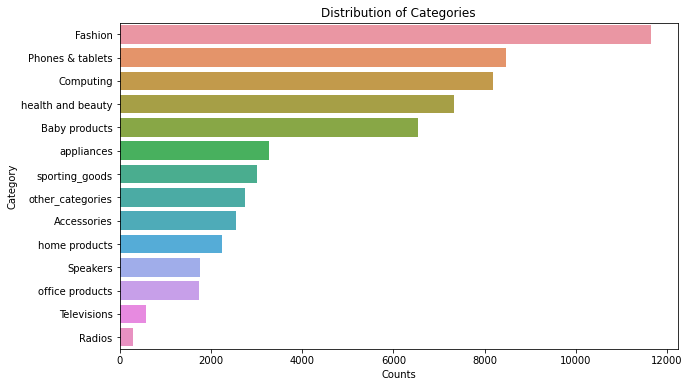

In [295]:
# Categorical column
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', 
              data=df,
              order=df['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Counts')
plt.ylabel('Category')
plt.show();

**Interpretation**

- The top few categories have significantly more products compared to those at the bottom, suggesting that certain categories (like `Fashion` and `Phone & tablets`) are highly populated in your dataset.  
- There’s a clear drop-off in frequency as you move down the list, which could indicate that some categories are more popular or that more products have been uploaded for those categories in the e-commerce catalog.

**Insights**

* *Customer Interest*: The top categories could reflect higher customer interest or demand, as vendors may upload more products in these areas.

* *Inventory Planning*: Retailers might focus more on stocking and promoting items in the most frequent categories.
* *Recommendation System Focus*: A recommendation system might prioritize building recommendations for these popular categories since they are likely to have more diverse options.

#### *Prices Distribution*

In [296]:
# Distribution Analysis
def plot_distribution(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, bins=20)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();

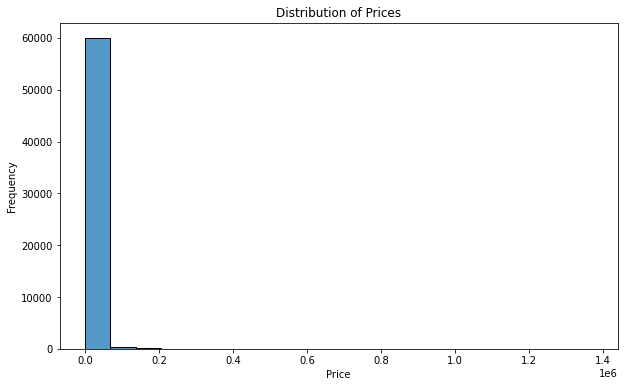

In [297]:
plot_distribution(df['price'], 'Distribution of Prices', 'Price', 'Frequency')

**Interpretation and Possible Implications**:

* *Imbalanced Dataset*: If you’re building a recommendation or classification system, this imbalance could bias the system towards the dominant category, potentially affecting its effectiveness across less-represented categories.

* *Customer Demand or Inventory Bias*: This could indicate a high customer demand for the dominant category, or it could reflect an inventory or data collection bias where most of the available products fall under this single category.

This kind of skewed distribution is common in datasets where one category or product type is significantly more popular or frequently added than others. 

In [298]:
# Since price is positively skewed, 

# Calculate IQR to detect outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[df['price'] > threshold]

print("Number of outliers:", len(outliers))
print(outliers[['product_name', 'price']].sort_values(by='price', ascending=False))

Number of outliers: 8288
                                            product_name      price
22410  Fashion The New Longines Master Series Women's...  1370668.0
43246  Samsung  98Q80CAU ,98Clas Q80 QLED UHD 4K Smar...   980000.0
43168  Samsung 85QN800D 85 Inch Neo QLED 8K Tizen OS,...   889995.0
42892  Skyworth 100 QLED FRAMELESS 4K UHD GOOGLE TV,...   800389.0
43264  Samsung 75'' Neo QLED 8K SMART TV (NEW MODEL 2...   780000.0
...                                                  ...        ...
41696  S-288 Mini Audio Power Amplifier 4.1-Channel D...     8544.0
8998   Skirt 2023 Fall Winter Knitted Two Piece Sets ...     8543.0
34961  Pioneer Deep Bass Car Subwoofer 12" 1500 Watts...     8541.0
21897  Zeblaze Ares 3 Pro Smart Bracelet Sports Watch...     8540.0
9601   Fashion Women's jacket thermal insulation prin...     8536.0

[8288 rows x 2 columns]


#### *Top 10 Sub Categories*

In [299]:
# Analyze the distribution of items across different subcategories

subcategory_counts = df['sub_category'].value_counts()

subcategory_counts

sub_category
mobile-accessories                        1902
mobile-phones                             1448
smartphones                               1231
computer-accessories                       875
audio-video-accessories                    853
                                          ... 
kettles                                     50
outdoor-patio-furniture-accessories         48
motorcycle-powersports                      46
sports-nutrition-testosterone-boosters      30
farm-ranch                                  14
Name: count, Length: 208, dtype: int64

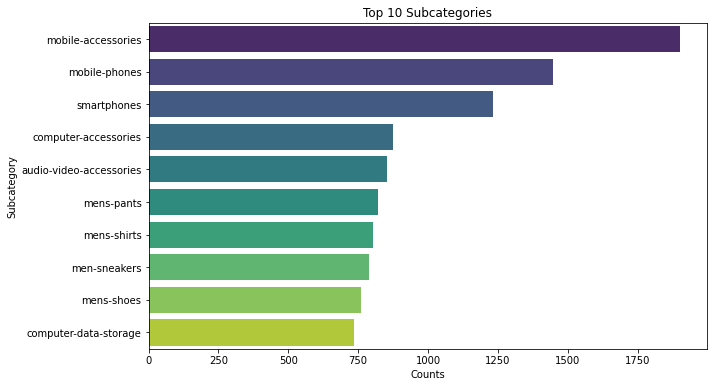

In [300]:
# Get the top 10 subcategories in descending order
top_10_subcategories = subcategory_counts.head(10)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_subcategories.values, y=top_10_subcategories.index, palette='viridis')
plt.title('Top 10 Subcategories')
plt.xlabel('Counts')
plt.ylabel('Subcategory')
plt.show();

**Potential Insights**

* *Customer Interest or Inventory Focus*: the top subcategories likely represent popular product types, high customer demand, or a focus on certain items.

#### *Bottom 10 Sub Categories*

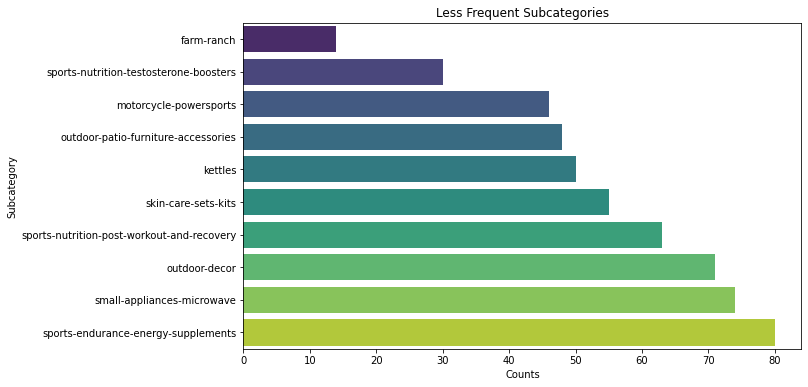

In [302]:
# Get the top 10 subcategories in descending order and then reverse them for ascending order
top_10_subcategories = subcategory_counts.tail(10).iloc[::-1]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_subcategories.values, y=top_10_subcategories.index, palette='viridis')
plt.title('Less Frequent Subcategories')
plt.xlabel('Counts')
plt.ylabel('Subcategory')
plt.show();

The above plot shows less frequent sub-categories potentially indicating lower popularity or inventory for these items.

#### *Users*

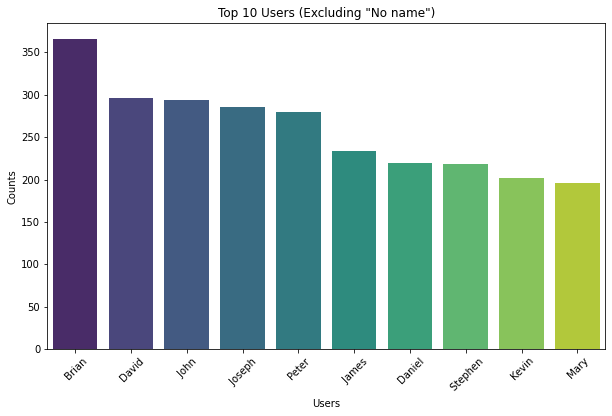

In [310]:
 # Filter out 'No name' entries from the user_name column
filtered_users = df[df['user_name'] != 'No name']

# Get the top 10 users by count
top_10_users = filtered_users['user_name'].value_counts().head(10)
    
# Plot the vertical bar chart for the top 10 users
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_users.index, y=top_10_users.values, palette='viridis')
plt.title('Top 10 Users (Excluding "No name")')
plt.xlabel('Users')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show();

**User Engagement**:

This distribution suggests that a few users are significantly more engaged than others in providing feedback. These top users are repeat customers or highly active reviewers who frequently purchase and leave feedback on products.

In [311]:
df.ratings.value_counts()

ratings
0.0    22714
5.0    21726
4.0     6443
1.0     4056
3.0     3462
2.0     1979
Name: count, dtype: int64